# N-Body Simulation - Solar System with N bodies and Nasa Horizons Data

Abstract : The goal of this Jupyter Notebook is to make an interactive ipython notebook available, with which one can simulate and produce 3D plots for the orbits of any object within the solar system during a settable simulation time $t_{max}$ and timestep $\Delta t$. This is achieved through computation of an N-Body simulation for the 10 main bodies within the solar systems frame of reference (the Sun, the 8 planets and the dwarf planet Pluto) using accurate initial position and velocity vector data from the NASA Horizons System, with the possibility of adding any number of extra N-Bodies to the simulation through the epherimedes provided by the same system (as long as their id/target_name and mass are known).

In [1]:
import numpy as np
import scipy as sp
import time
import scipy.constants as cs
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from astropy.time import Time
from astroquery.jplhorizons import Horizons

<ins> Gravitational acceleration function <ins>

For a problem of N bodies indexed by $i=1,...N$ and known initial positions $r_i=(x_i,y_i,z_i)^T$, velocities $v_i=(vx_i,vy_i,vz_i)^T$, and masses $m_i$, the function giving the gravitational acceleration being exerted by all other $j$ bodies on a given body $i$ as per Newton's inverse square law of gravitation is given in vector form by 

$\vec{a_i} = G \sum_{j=1}^{N-1} m_j \frac{\vec{r_j}-\vec{r_i}}{(|\vec{r_j}-\vec{r_i}|^2+\epsilon^2)^{3/2}}$

, with $G =  (6{,}674\,30\pm 0{,}000\,15) \cdot 10^{-11} \frac{m^3}{kg \cdot s^2}$ being the gravitational constant and epsilon a softening factor $\epsilon > 0 $ to prevent numerical errors during the integration. The vector components for the acceleration vector $\vec{a_i}(\vec{r_i}) \in R^3$ giving the values of the acceleration $(a_x,a_y,a_z)^T$ acting in the direction of each of the $(x,y,z)^T$ components can be thus computed in vector form using this formula. (Assuming an absence of other contributions towards the total energy of the system, only the gravitational acceleration needs to be taken into account here). 

Through proper vectorization, it is possible to optimize the code to run within shorter computation times $\tau$ by storing the positions $\vec{r_i}$, velocities $\vec{v_i}$ and pairwise distances $\vec{r_j} -\vec{r_i}$ as Matrices $M_{N}$, with the only downside to this method being higher RAM usage (up to a few gigabytes for large simulations, although the ones in this notebook don't use up more than 300mb at their maximum workload). However, adding more bodies N to the simulation, shortening the integration timesteps $dt$ or increasing the amount of time $t_{max}$ simulated can change this memory usage by increasing the simulation complexity $\Omega (N,t_{max},dt)  \propto MemoryUsage$ and if left unchecked crash the machine executing the code by causing a shortage of available RAM for other system processes!.

In [2]:
#Vectorial acceleration function
def a_t( r, m, epsilon):
    """
    Function of matrices returning the gravitational acceleration
    between N-bodies within a system with positions r and masses m
    -------------------------------------------------
    r  is a N x 3 matrix of object positions
    m is a N x 1 vector of object masses
    epsilon is the softening factor to prevent numerical errors
    a is a N x 3 matrix of accelerations
    -------------------------------------------------
    """  
    G = cs.gravitational_constant
    # positions r = [x,y,z] for all bodies in the N-Body System
    x = r[:,0:1]
    y = r[:,1:2]
    z = r[:,2:3]
    # matrices that store each pairwise body separation for each [x,y,z] direction: r_j - r_i
    dx = x.T - x
    dy = y.T - y
    dz = z.T - z
    #matrix 1/r^3 for the absolute value of all pairwise body separations together and 
    #resulting acceleration components in each [x,y,z] direction  
    inv_r3 = (dx**2 + dy**2 + dz**2 + epsilon**2)**(-1.5)
    ax = G * (dx * inv_r3) @ m
    ay = G * (dy * inv_r3) @ m
    az = G * (dz * inv_r3) @ m
    # pack together the three acceleration components
    a = np.hstack((ax,ay,az))
    return a

In order to estimate memory usage, one may use the code below, which computes a dummy set of position $r_i$, distance $dr_i$ and acceleration matrices $a_i$ to use for a rough calculation of the total memory used for a given number of N bodies to be simulated across a total amount of iterations $\frac{t_{max}}{dt}$. Since it doesn't actually compute the values inside the stored matrices and instead just outputs the memory an equivalent number of matrices filled with 0's and 1's would take up, this is to be taken as a rough estimate only as for wether or not the system memory might be sufficient to carry out the simulation in question. 

In [3]:
def omega(N, t_max, dt):
    """
    Dummy acceleration function to give an estimate of the total memory
    consumption for a simulation with N bodies, total simulation time 
    t_max and timestep dt
    -------------------------------------------------
    N is the amount of bodies in the simulation
    t_max is the total simulation time in years
    dt is the timestep for each integration in days
    -------------------------------------------------
    """
    epsilon = 1
    G = 1
    r = np.ones((N,3))
    v = np.ones((N,3)) 
    """although the velocities aren't actually taken into account for computing the 
    acceleration, they will be stored as Nx3 matrices for exactly as many iterations 
    in the integration loop itself and take up memory accordingly"""
    m = np.ones((N,1))
    # positions r = [x,y,z] for all bodies in the N-Body System
    x = r[:,0:1]
    y = r[:,1:2]
    z = r[:,2:3]
    # matrices that store each pairwise body separation for each [x,y,z] direction: r_j - r_i
    dx = x.T - x
    dy = y.T - y
    dz = z.T - z
    #matrix 1/r^3 for the absolute value of all pairwise body separations together and 
    #resulting acceleration components in each [x,y,z] direction 
    inv_r3 = (dx**2 + dy**2 + dz**2 + epsilon**2)**(-1.5)
    ax = G * (dx * inv_r3) @ m
    ay = G * (dy * inv_r3) @ m
    az = G * (dz * inv_r3) @ m
    # pack together the three acceleration components
    a = np.hstack((ax,ay,az))
    # sum the memory usage of each matrix storing the positions, distances and accelerations
    memory_usage_per_iteration = r.nbytes + v.nbytes + x.nbytes + y.nbytes + z.nbytes + dx.nbytes + dy.nbytes + dz.nbytes + ax.nbytes + ay.nbytes + az.nbytes + inv_r3.nbytes + a.nbytes 
    total_memory_usage = memory_usage_per_iteration * (t_max)/(dt*10e6) 
    return total_memory_usage #in megabytes

Thus to check if a simulation would occupy too much memory or not, one can simply run this function for the simulation parameters of choice. The estimated memory usage will then be returned in megabytes.

In [4]:
#Example for the estimated memory usage from a simulation with N = 13 bodies, t_max = 250 years and dt = 1 day
year = 365*24*60*60
day = 24*60*60
omega(13,250*year,1*day)

63.583

Should the output above exceed or be close to the amount of RAM available to the computer running the simulation, then the simulation won't succeed at producing an output and either the computer or the kernel will most likely crash upon having enough RAM taken away from other system processes. If computation time $\tau$ is not an issue/concern, the tensorial form of the acceleration function down below may also be used instead of the vectorial one so as to save memory usage and make the computation of simulations above the maximum complexity $\Omega _{max} \propto MaxMemoryUsage$ -given by the amount of available system memory- possible. Doing so is advised mostly for powerful systems, since the total computation time $\tau$ for the simulation will be increased significantly by a factor around the order of magnitude of $100$. Optimization through tensor optimization algorithms (such as Tensorflow or Pytorch) and acceleration through the use of GPU computation could most likely counterbalance this however, although such an implementation lies beyond the scope of this notebook (for now at least).

In [5]:
#Tensorial acceleration function
#def a_t( r, m, epsilon):
#    """
#    Function of tensors returning the gravitational acceleration
#    between N-bodies within a system with positions r and masses m
#    -------------------------------------------------
#    r  is a N x 3 matrix of object positions
#    m is a N x 1 vector of object masses
#    epsilon is the softening factor to prevent numerical errors
#    a is a N x 3 matrix of accelerations
#    """  
#    G = cs.gravitational_constant
#    N = r.shape[0];
#    a = np.zeros((N,3));
#    for i in range(N):
#        for j in range(N):
#            dx = r[j,0] - r[j,0];
#            dy = r[j,1] - r[j,1];
#            dz = r[j,2] - r[j,2];
#            inv_r3 = (dx**2 + dy**2 + dz**2 + epsilon**2)**(-1.5);
#            a[i,0] +=  G * (dx * inv_r3) * m[j];
#            a[i,1] +=  G * (dy * inv_r3) * m[j];
#            a[i,2] +=  G * (dz * inv_r3) * m[j];
#    return a

<ins> Nasa Horizons Querying Test <ins>

For the starting positions $\vec{r_i}(0)$ and initial velocities $\vec{v_i}(0)$ to feed into the simulation, the astroquery.jplhorizons package will provide accurate vectors from the JPL HORIZONS online solar system data and ephemeris computation service maintained by the Solar System Dynamics Group of NASAS Jet Propulsion Laboratory. Calling this package requires an available internet connection and can be used to get initial position data on planets, moons, dwarf planets, asteroids, comets and even space probes. Such a data request on the Halley comets position and velocity vectors on October 24th 2020 while using the sun as the frame of reference can be seen in the example code below, along with the resulting astropy table containing the data.

In [6]:
#Horizons query for vector data of an object (Halley comet in this example) in the solar system 
obj = Horizons(id='90000033', location="@sun", epochs=Time("2020-10-24").jd, id_type='id').vectors()
obj

targetname,datetime_jd,datetime_str,M1,M2,k1,k2,phasecoeff,x,y,z,vx,vy,vz,lighttime,range,range_rate
---,d,---,mag,mag,---,---,mag / deg,AU,AU,AU,AU / d,AU / d,AU / d,d,AU,AU / d
str9,float64,str30,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
1P/Halley,2459146.5,A.D. 2020-Oct-24 00:00:00.0000,5.5,13.6,8.0,5.0,0.03,-20.23429201168522,26.75245988529464,-9.979279250643343,0.0002661414548487454,0.0005311584521196234,-1.645219957546946e-05,0.2021189405105897,34.99580971331807,0.0002568533900694773


<ins> Get starting values for the N-body simulation from the Horizons system <ins>

Download the initial datasets through the astroquery.jplhorizons package for all 10 main bodies in the solar system (starting from the current barycenter inside the suns volume, through the inner and outer planets, all the way to Pluto). The starting date for the simulation and the initial values is set as the value $t_0$ and can be modified for any starting date required, so long as Horizons data on the positions/velocities of all objects on that date is available. 

In [7]:
#Conversion Units
AU = 149597870700
D = 24*60*60
#Simulation starting date in Y/M/D
t_0 = "2018-10-26"
#Get Starting Parameters for Sun-Pluto from Nasa Horizons
r_list = []
v_list = []
m_list = [[1.989e30],[3.285e23],[4.867e24],[5.972e24],[6.39e23],[1.8989e27],[5.683e26],[8.681e25],[1.024e26],[1.309e22]] #Object masses for Sun-Pluto
plot_colors = ['green','brown','orange','blue','red','red','orange','cyan','blue','brown']
plot_labels = ['Barycenter Drift','Mercury Orbit','Venus Orbit','Earth Orbit','Mars Orbit','Jupiter Orbit','Saturn Orbit','Uranus Orbit','Neptune Orbit','Pluto Orbit']
for i in range(0,10):
    obj = Horizons(id=i, location="@sun", epochs=Time(t_0).jd, id_type='id').vectors()
    r_obj = [obj['x'][0], obj['y'][0], obj['z'][0]]
    v_obj = [obj['vx'][0], obj['vy'][0], obj['vz'][0]]
    r_list.append(r_obj)
    v_list.append(v_obj)
#Get Starting Parameters for any extra object to add into the simulation with input for id/mass/plot_color/plot_label
def add_simulation_object(Id_obj,m_obj, plot_color, plot_label):
    obj = Horizons(id=Id_obj, location="@sun", epochs=Time(t_0).jd, id_type='id').vectors()
    r_obj = [obj['x'][0], obj['y'][0], obj['z'][0]]
    v_obj = [obj['vx'][0], obj['vy'][0], obj['vz'][0]]
    r_list.append(r_obj)
    v_list.append(v_obj)
    m_list.append([m_obj])
    plot_colors.append(plot_color)
    plot_labels.append(plot_label)

Additional objects can be added to the simulation by using the add_simulation_object function, with the required parameters being the wanted object's Horizons ID, mass (about which Horizons doesn't deliver data), as well as a color and label for the plotted orbit. Down below is the code for the addition of comet NEOWISE and SpaceX's Starman payload to the simulation.

In [8]:
#Sample ID for Neowise
id_neowise = '90004475'
m_neowise = 5e13
#Sample ID for Space X's Starman
id_starman = 'SpaceX Roadster'
m_starman = 1300
#Add NEOWISE and Starman to the simulation
add_simulation_object('90004475',5e13, 'black','Comet Neowise')
add_simulation_object('SpaceX Roadster',1300, 'pink','Starman')
add_simulation_object('90000033',1e14, 'gray','Comet Halley')

Finally, all object datasets are converted to numpy arrays as well as SI units and packed together to be used as inputs for the numerical integration.

In [9]:
#Convert object staring value lists to numpy
r_i = np.array(r_list)*AU
v_i = np.array(v_list)*AU/D
m_i = np.array(m_list)
#pack together as list for the simulation function
horizons_data = [r_i,v_i,m_i]

<ins> Integrator Function <ins>

In order for the actual positions $\vec{r_i}(t) \ \ \forall t \in [t_0,t_0+t_{max}]$ to be computed, the values returned by the function computing the gravitational acceleration for each consecutive value $\vec{r_i}(t_n+dt)$ starting with $t_{n=0} = t_0$ need to be computed consecutively at fixed timesteps $dt$. This is achieved through a Leapfrog-Algorithm using what's called a Kick-Drift-Kick scheme in which the particle is accelerated to its updated velocity 

$v_i (t_n+\frac{dt}{2})=v_i(t_n)+a_i(t_n+dt)\frac{dt}{2}$

after half a timestep $\frac{dt}{2}$, then its position is updated by a full timestep $dt$ using said velocity to compute its new value 

$r_i(t_n+dt)=r_i(t_n)+v_i(t_n+\frac{dt}{2})dt$

, and finally its velocity 

$v_i(t_n+dt)=v_i(t_n+\frac{dt}{2})+a_i(t_n+dt)\frac{dt}{2}$

is updated to reflect the other half of the timestep $\frac{dt}{2}$ before the loop starts over again from the beginning using the updated positions $r_i(t_n+dt)$ and velocities $v_i(t_n+dt)$.

In [10]:
def simulate_solar_system(N,dN,starting_values): #
    t0_sim_start = time.time()
    t = 0
    t_max = 365*24*60*60*N #N year simulation time
    dt = 60*60*24*dN #dN day time step
    epsilon_s = 0.01 #softening default value
    r_i = starting_values[0]
    v_i = starting_values[1]
    m_i = starting_values[2]
    a_i = a_t(r_i, m_i, epsilon_s)
    ram_usage_estimate = omega(len(r_i), t_max, dt) #returns the estimated ram usage for the simulation
    # Simulation Main Loop using a Leapfrog Kick-Drift-Kick Algorithm
    k = int(t_max/dt)
    r_save = np.zeros((r_i.shape[0],3,k+1))
    r_save[:,:,0] = r_i
    for i in range(k):
        # (1/2) kick
        v_i += a_i * dt/2.0
        # drift
        r_i += v_i * dt
        # update accelerations
        a_i = a_t(r_i, m_i, epsilon_s)
        # (2/2) kick
        v_i += a_i * dt/2.0
        # update time
        t += dt
        #update list
        r_save[:,:,i+1] = r_i
    sim_time = time.time()-t0_sim_start
    print('The required computation time for the N-Body Simulation was', round(sim_time,3), 'seconds. The estimated memory usage was', round(ram_usage_estimate,3), 'megabytes of RAM.')
    return r_save

This numerical integration loop for the system of second order ODEs $\frac{d\vec{r_i}}{dt^2}$ describing the motion of all N bodies yields a good balance between conserving the total energy $E = E_{Pot} + E_{Kin}$ of the system/preventing chaotic behaviour due to diverging numerical errors $u_{\Phi} (t_{max},dt)$ for longer simulations and computational efficiency at the cost of memory usage while using the vectorized form of the numerical acceleration function.

<ins> Simulation Data Plots <ins>

The simulated positions can be plotted in a 3D-Plot using the matplotlib.pyplot and axes3D packages. Since the all the shifting positions of the different bodies N inside the simulation are computed, they can be plotted either individually or within the same plot. A plot for the drift of the solar systems barycenter by itself as simulated for a timeframe of $t_{max} = 2 \ years$ at a timestep $dt= 1 \ day$ using a 12 body system of the Sun, the 8 planets and other, lesser bodies is given below. This drift corresponds to the movement of the solar system as a whole induced by the combined gravity of all of these 12 bodies shifting the barycenters position periodically. 

Running the simulation also returns the required computation time $\tau$ and estimated memory usage $\propto \Omega$ automatically.

The required computation time for the N-Body Simulation was 0.048 seconds. The estimated memory usage was 0.509 megabytes of RAM.


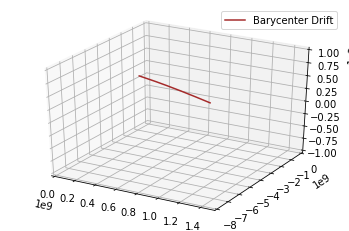

In [11]:
#Run simulation for 2 years at a 1 day time-step
r_save = simulate_solar_system(2,1,horizons_data) 
#Plot-Axis
fig = plt.figure()
ax = fig.gca(projection='3d')
ax.set_xlim3d(0,1.5e9)
ax.set_ylim3d(-8e9,0)
ax.set_zlim3d(-1e8,1e8)
#Plot of Solar System Barycenter
ax.plot3D(r_save[0,0,:],r_save[0,1,:],r_save[0,2,:], 'brown',label='Barycenter Drift')
ax.legend(loc = 'upper right')

The same simulated data can also be used to return a plot of all the inner planets as computed by the integrator. Choosing appropiate plot boundaries through the ax.set matplotlib function for the plotted objects and choosing which to plot based on that is crucial for anything to be discernible within the plot.

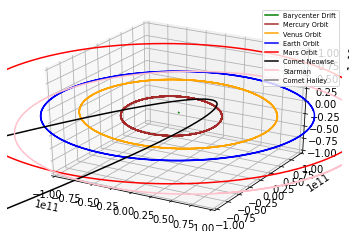

In [12]:
#Plot for the inner planets
fig = plt.figure()
ax = fig.gca(projection='3d')
ax.set_xlim3d(-1e11,1e11)
ax.set_ylim3d(-1e11,1e11)
ax.set_zlim3d(-1e11,1e11)
#Input sim. data
for i in range(0,5): #Plots the inner planets
    ax.plot3D(r_save[i,0,:],r_save[i,1,:],r_save[i,2,:], plot_colors[i],label=plot_labels[i])
if len(r_i)>=10:
    for i in range(10,len(r_i)): #Plots any additional objects
        ax.plot3D(r_save[i,0,:],r_save[i,1,:],r_save[i,2,:], plot_colors[i],label=plot_labels[i])
ax.legend(loc = 'upper right', prop={'size': 6.5})
plt.savefig('Plots/3D_Plots_Inner_Planets.pdf',dpi=1200)

As plotting the inner and outer planets at the same time would also make one or the other very difficult to view due the latters orbital periods and diameters being much larger than those of the inner planets, another simulation for a larger timeframe of $t_{max} = 250 \ years$ at the same timestep of $dt = 1 \ day$ was computed and plotted with larger boundaries below. This plot also includes the orbits of the long- and short period comets NEOWISE F4 and Halley, whose respectively strongly elliptic $e_{Halley} = 0.967$ and parabolic $e_{Neowise} = 0.99921$ orbital eccentricities can be appreciated in their plots.

The required computation time for the N-Body Simulation was 6.126 seconds. The estimated memory usage was 63.583 megabytes of RAM.


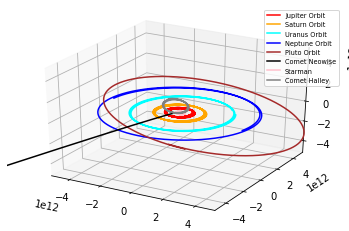

In [13]:
#Run simulation for 250 years at a 1 day time-step
r_save = simulate_solar_system(250,1,horizons_data)
#Plot for the outer planets
fig2 = plt.figure()
ax = plt.axes(projection='3d')
ax.set_xlim3d(-50e11,50e11)
ax.set_ylim3d(-50e11,50e11)
ax.set_zlim3d(-50e11,50e11)
#Input sim. data
for i in range(5,10): #Plots the outer planets
    ax.plot3D(r_save[i,0,:],r_save[i,1,:],r_save[i,2,:], plot_colors[i],label=plot_labels[i])
if len(r_i)>=10:
    for i in range(10,len(r_i)): #Plots any additional objects
        ax.plot3D(r_save[i,0,:],r_save[i,1,:],r_save[i,2,:], plot_colors[i],label=plot_labels[i])
ax.legend(loc = 'upper right', prop={'size': 6.5})
plt.savefig('Plots/3D_Plots_Outer_Planets.pdf',dpi=1200)

For such a long simulation time of $t_{max}=250 \ years$, the sinusoidal, oscillating shape of the barycenters drift -caused mainly by the periodicity of the planets orbiting around the barycenter as they slowly shift its position- becomes recognizable in its individual plot.

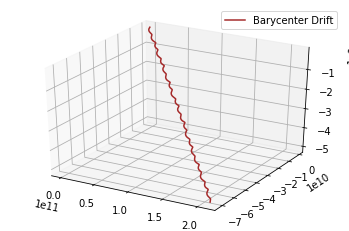

In [14]:
#Plot-Rahmen 
fig = plt.figure()
ax = fig.add_subplot(111,projection='3d')
#Plot des Sonnenmittelpunktes/Baryozentrums des Sonnensystems
ax.plot3D(r_save[0,0,:],r_save[0,1,:],r_save[0,2,:], 'brown',label='Barycenter Drift')
ax.legend(loc = 'upper right')

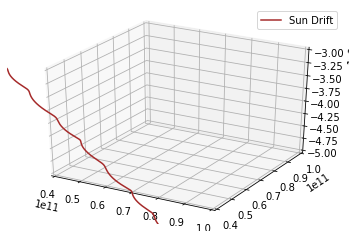

In [15]:
#Plot-Rahmen 
fig = plt.figure()
ax = fig.gca(projection='3d')
ax.set_xlim3d(4e10,1e11)
ax.set_ylim3d(4e10,1e11)
ax.set_zlim3d(-5e9,-3e9)
#Plot des Sonnenmittelpunktes/Baryozentrums des Sonnensystems
ax.plot3D(r_save[0,0,:],r_save[0,1,:],r_save[0,2,:], 'brown',label='Sun Drift')
ax.legend(loc = 'upper right')

<ins> Extreme long time Simulation <ins>

The acceleration and integrator function are also capable of simulating the orbits of objects within the outer Kuiper belt region of the solar system. For this and due to the distance/time scales involved, it is possible to simplify the inner region of the solar system (that is the Sun and all of the planets) as a fixed mass at the coordinate origin, acting upon the much farther objects simulated inside the Kuiper belt region. This is both to save computational resources as well as to make a larger timestep of $dt=1 \ year$ for the simulated timeframe of $t_{max} = 35000 \ years$ possible without causing the simulation of the inner planets to break down due to excessive linearization. By doing so, it is also possible to reduce memory usage to acceptable levels, as a simulation of 14 bodies for a total time of $t_{max} = 35000 \ years$ at a timestep $dt = 1 \ day$ would take up a very large amount of memory, as shown here with the output returning the estimated memory usage in megabytes 

In [16]:
#Check estimated memory usage for a 14 body, 35000 years long simulation at a timestep dt = 1 day for which 
omega(13,35000*year,1*day)

8901.62

A sample code implementing this aforementioned simplification is thus given below, with the initial data being set using new lists and names so as not to erase the previous initial data on the inner region of the solar system retrieved through the Horizons system. The computed objects shown are the 4 main dwarf planets within the Kuiper belt region of the solar system, Pluto, Eris, Sedna as well as the recently dicovered Leleakuhonua. 

In [17]:
#Set new simulation
r_kuiper = [[0,0,0]]
v_kuiper = [[0,0,0]]
m_kuiper = [[2e30]]
kuiper_plot_colors = ['red']
kuiper_plot_labels = ['Solar System']
#Kuiper Belt Simulation starting Parameters
def add_kuiper_simulation_object(Id_obj,m_obj, plot_color, plot_label):
    obj = Horizons(id=Id_obj, location="@sun", epochs=Time(t_0).jd, id_type='id').vectors()
    r_obj = [obj['x'][0], obj['y'][0], obj['z'][0]]
    v_obj = [obj['vx'][0], obj['vy'][0], obj['vz'][0]]
    r_kuiper.append(r_obj)
    v_kuiper.append(v_obj)
    m_kuiper.append([m_obj])
    kuiper_plot_colors.append(plot_color)
    kuiper_plot_labels.append(plot_label)
#Add Starting Values for the Solar System, Sedna and Leleakuhonua
add_kuiper_simulation_object(9,1e20,'black','Pluto')
add_kuiper_simulation_object(136199,1e20,'pink','Eris')
add_kuiper_simulation_object(90377,10e20,'gray','Sedna')
add_kuiper_simulation_object(541132,1e20,'brown','Leleakuhonua')
#Convert object staring value lists to numpy
r_kuiper_i = np.array(r_kuiper)*AU
v_kuiper_i = np.array(v_kuiper)*AU/D
m_kuiper_i = np.array(m_kuiper)
#pack together as list for the simulation function
horizons_kuiper_data = [r_kuiper_i,v_kuiper_i,m_kuiper_i]

In [18]:
#Run simulation for 35000 years at a 1 year time-step
r_save = simulate_solar_system(35000,365,horizons_kuiper_data)

The required computation time for the N-Body Simulation was 2.697 seconds. The estimated memory usage was 4.9 megabytes of RAM.


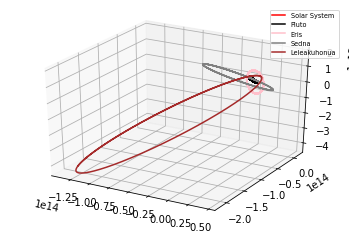

In [19]:
#Plot for the kuiper objects
fig2 = plt.figure()
ax = fig2.add_subplot(111,projection='3d')
#Input sim. data
for i in range(0,len(r_kuiper_i)): #Plots the outer planets
    ax.plot3D(r_save[i,0,:],r_save[i,1,:],r_save[i,2,:], kuiper_plot_colors[i],label=kuiper_plot_labels[i])
ax.legend(loc = 'upper right', prop={'size': 6.5})
plt.savefig('Plots/3D_Plots_Kuiper_Objects.pdf',dpi=1200)